# <center> MATH&ML-12. Временные ряды. Часть I

### Юнит 3. Тренд, сезонность, шум. Инструменты для декомпозиции временного ряда

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.api import SimpleExpSmoothing
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg
import requests

In [238]:
df = pd.read_csv("data/AirPassengers.zip", index_col='Month', parse_dates=['Month'])
df

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
...,...
1960-08-01,606
1960-09-01,508
1960-10-01,461


<Axes: xlabel='Month'>

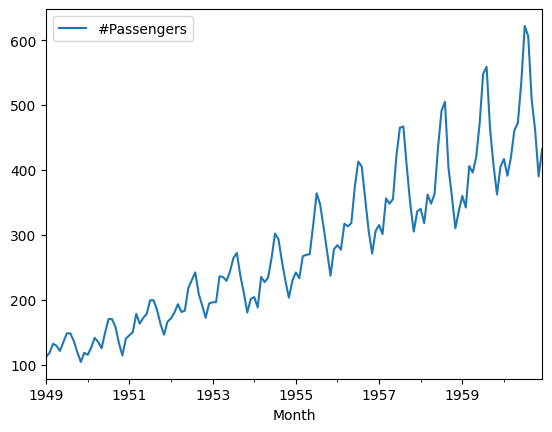

In [239]:
df.plot(y='#Passengers')

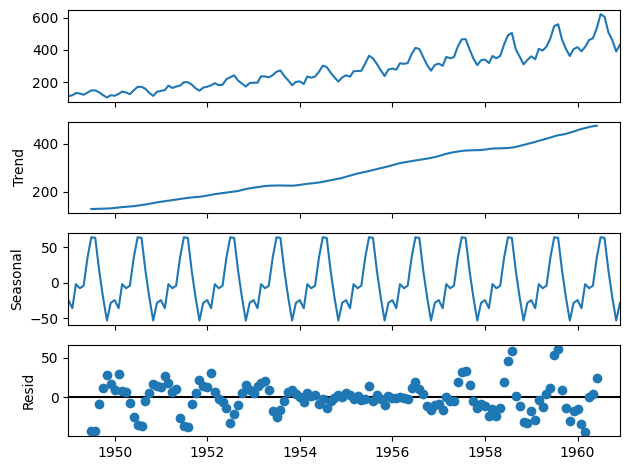

In [240]:
#импортируем библиотеку 
# from statsmodels.tsa.seasonal import seasonal_decompose
#производим декомпозицию временного ряда 
decomposition = seasonal_decompose(df)
fig = decomposition.plot()
plt.show()

### Юнит 4. Экспоненциальное сглаживание

In [241]:
def exp_smth(x_t, a, s_t_1):
    return a * x_t + (1 - a) * s_t_1

data = np.array([15, 20, 25, 30, 25, 27])
a = 0.7
s = np.zeros(6)
s[0] = data[0]

for i in range(1, len(data)):
    s[i] = exp_smth(data[i], a, s[i-1])

print(s)

[15.      18.5     23.05    27.915   25.8745  26.66235]


In [242]:
# from statsmodels.tsa.api import SimpleExpSmoothing

ses = SimpleExpSmoothing(data)

alpha = 0.7

model = ses.fit(smoothing_level = alpha, optimized = False)

forecast = model.forecast(1)

print(forecast)

[26.66235]


### Юнит 5. Стационарность

ADF Statistic: -4.808291253559765
p-value: 5.2434129901498554e-05
Critical Values:
	1%: -3.449
	5%: -2.870
	10%: -2.571


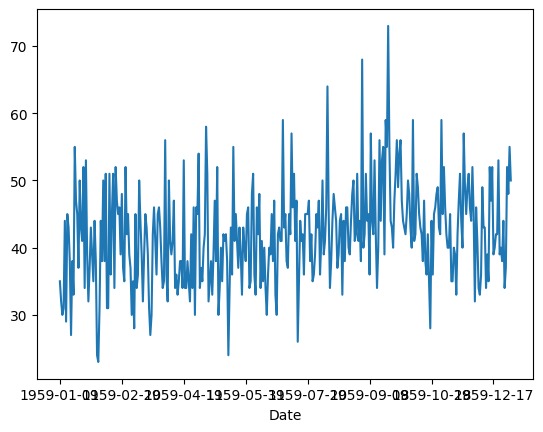

In [243]:
# import pandas as pd
# from statsmodels.tsa.stattools import adfuller

df = pd.read_csv(
	"data/daily-total-female-births.zip", 
    header=0, 
    index_col=0
).squeeze("columns")

result = adfuller(df.values)

print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")
print("Critical Values:")

for key, value in result[4].items():
	print(f"\t{key}: {value:.3f}")
 
fig = df.plot()
plt.show()

In [244]:
# Полученный временной ряд стационарен. Если бы он
# был нестационарным, нужно было бы дополнительно привести
# его трансформировать:

# df_diff_1 = df.diff().dropna()
# test1 = adfuller(df_diff_1)
# print ('adf: ', test1[0])
# print ('p-value: ', test1[1])
# print ('Critical values: ', test1[4])
# if test1[0]> test1[4]['5%']: 
#     print ('ряд нестационарен')
# else:
#     print ('ряд стационарен')

### Юнит 6. Автокорреляция

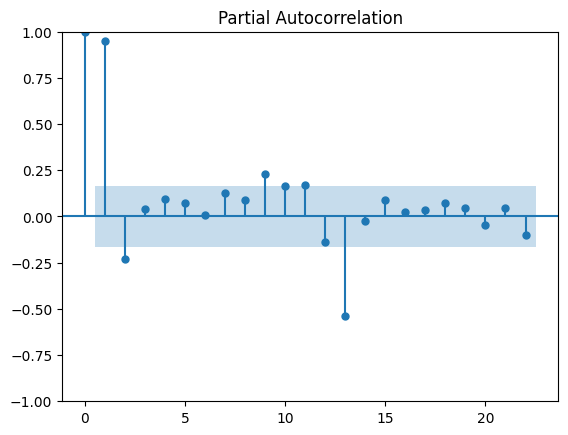

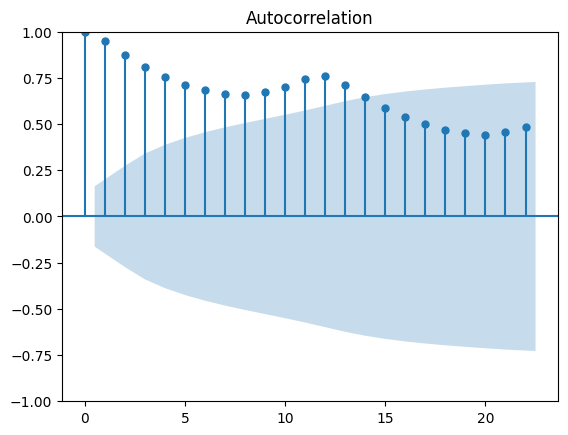

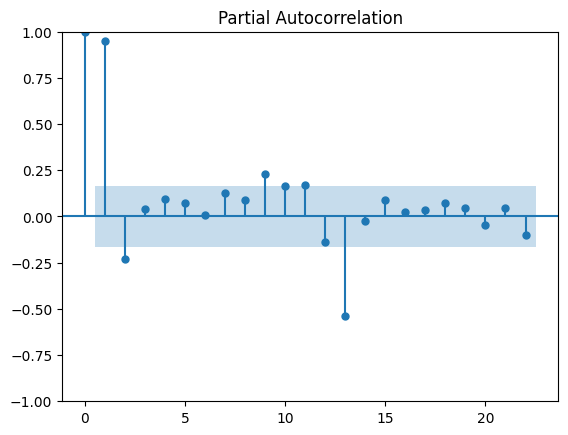

In [245]:
# from statsmodels.graphics.tsaplots import plot_acf

df = pd.read_csv("data/AirPassengers.zip", index_col='Month', parse_dates=['Month'])
# display(df)
plot_acf(df)
plot_pacf(df)

In [246]:
# import requests
# import pandas as pd

url = "https://raw.githubusercontent.com/jenfly/opsd/master/opsd_germany_daily.csv"

# Скачиваем содержимое
response = requests.get(url)
response.raise_for_status()  # Проверяем успешность запроса

# Сохраняем в файл
with open("data/opsd_germany_daily.csv", "wb") as f:
    f.write(response.content)

# Или сразу читаем в DataFrame
df = pd.read_csv(url, sep=",")
print(df)

            Date  Consumption     Wind   Solar  Wind+Solar
0     2006-01-01   1069.18400      NaN     NaN         NaN
1     2006-01-02   1380.52100      NaN     NaN         NaN
2     2006-01-03   1442.53300      NaN     NaN         NaN
3     2006-01-04   1457.21700      NaN     NaN         NaN
4     2006-01-05   1477.13100      NaN     NaN         NaN
...          ...          ...      ...     ...         ...
4378  2017-12-27   1263.94091  394.507  16.530     411.037
4379  2017-12-28   1299.86398  506.424  14.162     520.586
4380  2017-12-29   1295.08753  584.277  29.854     614.131
4381  2017-12-30   1215.44897  721.247   7.467     728.714
4382  2017-12-31   1107.11488  721.176  19.980     741.156

[4383 rows x 5 columns]


Date — дата (в формате гггг-мм-дд);  
Consumption — потребление электроэнергии (ГВтч);  
Wind — производство ветровой энергии (ГВтч);  
Solar — производство солнечной энергии (ГВтч);  
Wind+Solar — сумма производства ветровой и солнечной энергии (ГВтч).  

In [247]:
# from statsmodels.tsa.stattools import adfuller
# from statsmodels.tsa.ar_model import AutoReg

# тест на стационарность
result = adfuller(df['Consumption'].values)

if result[0] > result[4]['5%']: 
    print ('Ряд нестационарен')
else:
    print ('Ряд стационарен')

Ряд стационарен


In [248]:
# Разделим выборки на тренировочную и тестовую
train_data = df['Consumption'][:len(df)-100]
test_data = df['Consumption'][len(df)-100:]

#Обучение модели
ar_model = AutoReg(train_data, lags=8).fit()
print(ar_model.summary())

# Сделаем предсказание
# Метод predict требует два обязательных параметра — метки начала 
# и окончания предсказания. Метка начала предсказания будет равна 
# количеству данных в обучающей выборке, так как нас интересует прогноз 
# со следующего дня. Метка окончания в нашем случае будет равна 
# len(train_data)+100, что эквивалентно len(df)-1, так как len(df) = 
# len(train_data) + len(test_data).
pred = ar_model.predict(start=len(train_data), end=(len(df)-1), dynamic=False)

                            AutoReg Model Results                             
Dep. Variable:            Consumption   No. Observations:                 4283
Model:                     AutoReg(8)   Log Likelihood              -24231.812
Method:               Conditional MLE   S.D. of innovations             70.058
Date:                Sun, 02 Nov 2025   AIC                          48483.625
Time:                        19:18:53   BIC                          48547.230
Sample:                             8   HQIC                         48506.095
                                 4283                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const            121.2792     14.444      8.397      0.000      92.969     149.589
Consumption.L1     0.6393      0.013     47.751      0.000       0.613       0.666
Consumption.L2    -0.0966      0.011

### Юнит 8. Итоговая практика

In [249]:
book_data = pd.read_csv('data/tovar_moving.zip', index_col=['date'], parse_dates=['date'])
display(book_data)

,qty
date,
2009-12-25,72314.0
2009-12-26,66586.0
2009-12-27,125199.0
2009-12-28,91544.0
2009-12-29,76995.0
...,...
2013-11-28,320717.0
2013-11-29,444416.0
2013-11-30,323577.0


In [250]:
# Поделим выборки
train_data = book_data.iloc[:-1]
test_data = book_data.iloc[-1]

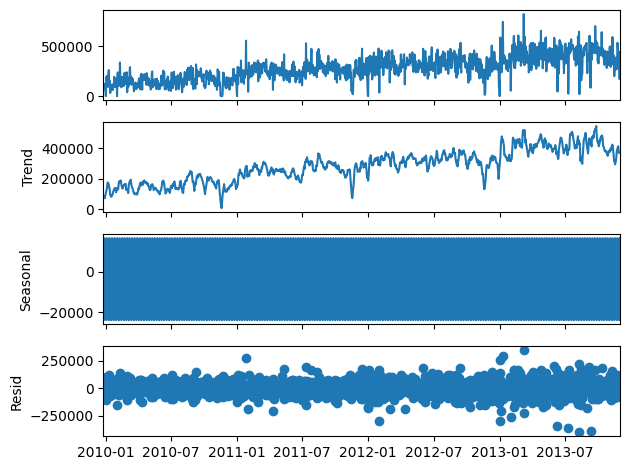

In [251]:
decomposition = seasonal_decompose(book_data)
decomposition.plot()
plt.show()

In [252]:
ses = SimpleExpSmoothing(train_data)
alpha = 0.7
model = ses.fit(smoothing_level = alpha, optimized = False)
exp_pred = model.forecast(1)
print('Предсказанное значение:', exp_pred)
print('Фактическое значение:', test_data)

Предсказанное значение: 2013-12-02    225015.522647
Freq: D, dtype: float64
Фактическое значение: qty    423846.0
Name: 2013-12-02 00:00:00, dtype: float64


c:\Users\telis\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [253]:
def stat_test(df):
    test = adfuller(df)
    print ('adf: ', test[0] )
    print ('p-value: ', test[1])
    print('Critical values: ', test[4])
    if test[0]> test[4]['5%']: 
        print ('есть единичные корни, ряд не стационарен')
    else:
        print ('единичных корней нет, ряд стационарен')

stat_test(train_data)

adf:  -2.255302641033794
p-value:  0.18678903123416657
Critical values:  {'1%': -3.434973278556316, '5%': -2.8635818545830376, '10%': -2.567857072940785}
есть единичные корни, ряд не стационарен


In [254]:
train_data_1st_grade = train_data.diff(1).dropna()
stat_test(train_data_1st_grade)

adf:  -13.780727380503777
p-value:  9.307227521340049e-26
Critical values:  {'1%': -3.434973278556316, '5%': -2.8635818545830376, '10%': -2.567857072940785}
единичных корней нет, ряд стационарен


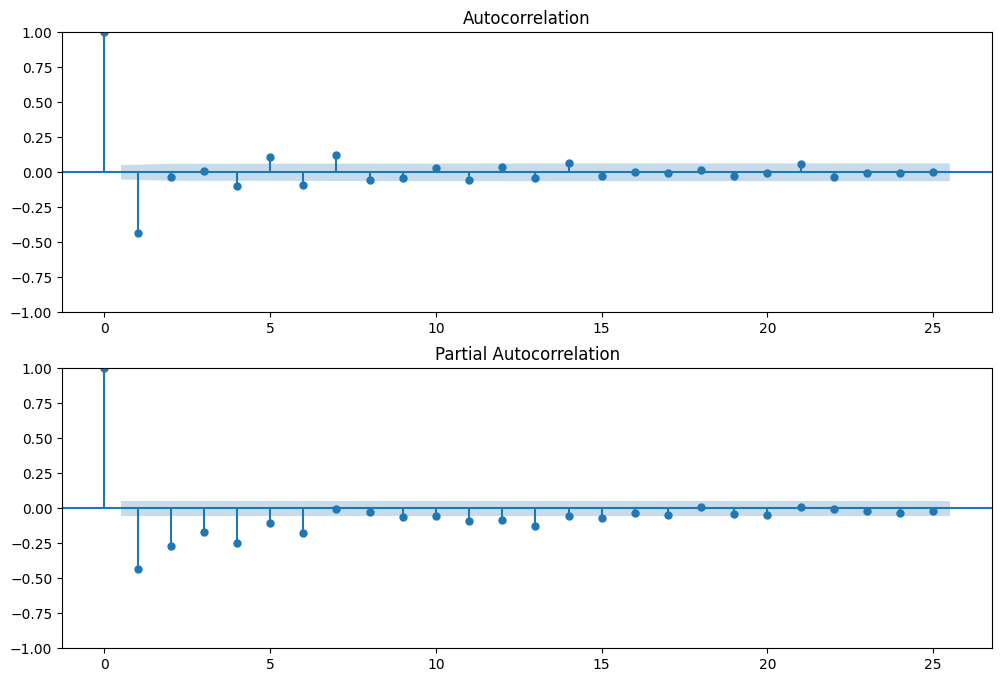

In [255]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(train_data_1st_grade.values.squeeze(), lags=25, ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(train_data_1st_grade, lags=25, ax=ax2)

In [256]:
#Не понятно, какой p брать. Возьму все и посмотрю, какой лучше
p = 3
ar_model = AutoReg(train_data, lags=p).fit()
print(ar_model.summary())

ar_pred = ar_model.predict(start=len(train_data), end=(len(train_data)+3), dynamic=False)
ar_pred

                            AutoReg Model Results                             
Dep. Variable:                    qty   No. Observations:                 1438
Model:                     AutoReg(3)   Log Likelihood              -18312.813
Method:               Conditional MLE   S.D. of innovations          84339.306
Date:                Sun, 02 Nov 2025   AIC                          36635.625
Time:                        19:18:54   BIC                          36661.970
Sample:                    12-28-2009   HQIC                         36645.461
                         - 12-01-2013                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       4.788e+04   6101.171      7.848      0.000    3.59e+04    5.98e+04
qty.L1         0.3860      0.026     14.945      0.000       0.335       0.437
qty.L2         0.2303      0.027      8.509      0.0

c:\Users\telis\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\telis\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\deterministic.py:308: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


2013-12-02    283545.516956
2013-12-03    265992.547230
2013-12-04    252438.300047
2013-12-05    267360.867240
Freq: D, dtype: float64

In [257]:
p = 4
ar_model = AutoReg(train_data, lags=p).fit()
print(ar_model.summary())

ar_pred = ar_model.predict(start=len(train_data), end=(len(train_data)+3), dynamic=False)
ar_pred

                            AutoReg Model Results                             
Dep. Variable:                    qty   No. Observations:                 1438
Model:                     AutoReg(4)   Log Likelihood              -18287.739
Method:               Conditional MLE   S.D. of innovations          83618.266
Date:                Sun, 02 Nov 2025   AIC                          36587.477
Time:                        19:18:54   BIC                          36619.087
Sample:                    12-29-2009   HQIC                         36599.279
                         - 12-01-2013                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       4.187e+04   6177.495      6.778      0.000    2.98e+04     5.4e+04
qty.L1         0.3576      0.026     13.645      0.000       0.306       0.409
qty.L2         0.1991      0.028      7.235      0.0

c:\Users\telis\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\telis\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\deterministic.py:308: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


2013-12-02    282230.331444
2013-12-03    288443.476599
2013-12-04    271963.695557
2013-12-05    265154.546278
Freq: D, dtype: float64

In [258]:
p = 5
ar_model = AutoReg(train_data, lags=p).fit()
print(ar_model.summary())

ar_pred = ar_model.predict(start=len(train_data), end=(len(train_data)+3), dynamic=False)
ar_pred

                            AutoReg Model Results                             
Dep. Variable:                    qty   No. Observations:                 1438
Model:                     AutoReg(5)   Log Likelihood              -18239.009
Method:               Conditional MLE   S.D. of innovations          81545.079
Date:                Sun, 02 Nov 2025   AIC                          36492.018
Time:                        19:18:54   BIC                          36528.890
Sample:                    12-30-2009   HQIC                         36505.785
                         - 12-01-2013                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.316e+04   6120.094      5.419      0.000    2.12e+04    4.52e+04
qty.L1         0.3276      0.026     12.700      0.000       0.277       0.378
qty.L2         0.1631      0.027      6.003      0.0

c:\Users\telis\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\telis\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\deterministic.py:308: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


2013-12-02    303615.457634
2013-12-03    293312.930319
2013-12-04    314831.710262
2013-12-05    300905.576007
Freq: D, dtype: float64

In [260]:
p = 6
ar_model = AutoReg(train_data, lags=p).fit()
print(ar_model.summary())

ar_pred = ar_model.predict(start=len(train_data), end=(len(train_data)+3), dynamic=False)
ar_pred

                            AutoReg Model Results                             
Dep. Variable:                    qty   No. Observations:                 1438
Model:                     AutoReg(6)   Log Likelihood              -18221.056
Method:               Conditional MLE   S.D. of innovations          81248.064
Date:                Sun, 02 Nov 2025   AIC                          36458.111
Time:                        19:21:40   BIC                          36500.246
Sample:                    12-31-2009   HQIC                         36473.844
                         - 12-01-2013                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.047e+04   6160.175      4.946      0.000    1.84e+04    4.25e+04
qty.L1         0.3074      0.026     11.654      0.000       0.256       0.359
qty.L2         0.1582      0.027      5.835      0.0

c:\Users\telis\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\telis\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\deterministic.py:308: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


2013-12-02    318174.284553
2013-12-03    305957.697024
2013-12-04    319968.538072
2013-12-05    320131.312459
Freq: D, dtype: float64